# Generate Population from National Transport Survey Data

Provided example is toy data. You can access [UK travel survey from 2002-2021](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340) from the [UK Data Service](https://beta.ukdataservice.ac.uk).

In [2]:
from pathlib import Path

import pandas as pd
from pam import read
from pam.core import Population
from pam.utils import datetime_to_matsim_time

from caveat.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.describe.transitions import sequence_prob_plot

In [3]:
trips_csv = "data/dummyNTS/trips.tab"
year = 2021
write_dir = Path("tmp")

In [4]:
travel_diaries = pd.read_csv(
    trips_csv,
    sep="\t",
    usecols=[
        "TripID",
        "JourSeq",
        "DayID",
        "IndividualID",
        "HouseholdID",
        "MainMode_B04ID",
        "TripPurpFrom_B01ID",
        "TripPurpTo_B01ID",
        "TripStart",
        "TripEnd",
        "TripOrigGOR_B02ID",
        "TripDestGOR_B02ID",
        "W5",
        "SurveyYear",
    ],
)

travel_diaries = travel_diaries.rename(
    columns={  # rename data
        "TripID": "tid",
        "JourSeq": "seq",
        "DayID": "day",
        "IndividualID": "iid",
        "HouseholdID": "hid",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
        "W5": "freq",
        "SurveyYear": "year",
    }
)

travel_diaries = travel_diaries[travel_diaries.year == year]

travel_diaries.tst = pd.to_numeric(travel_diaries.tst, errors="coerce")
travel_diaries.tet = pd.to_numeric(travel_diaries.tet, errors="coerce")
travel_diaries.ozone = pd.to_numeric(travel_diaries.ozone, errors="coerce")
travel_diaries.dzone = pd.to_numeric(travel_diaries.dzone, errors="coerce")
travel_diaries.freq = pd.to_numeric(travel_diaries.freq, errors="coerce")

travel_diaries["did"] = travel_diaries.groupby("iid")["day"].transform(
    lambda x: pd.factorize(x)[0] + 1
)
travel_diaries["pid"] = [
    f"{i}-{d}" for i, d in zip(travel_diaries.iid, travel_diaries.did)
]

travel_diaries = travel_diaries.loc[
    travel_diaries.groupby("pid")
    .filter(lambda x: pd.isnull(x).sum().sum() < 1)
    .index
]
# travel_diaries.freq = travel_diaries.freq / travel_diaries.groupby("iid").day.transform("nunique")
travel_diaries.loc[travel_diaries.tet == 0, "tet"] = 1440

travel_diaries = travel_diaries.drop(
    ["tid", "iid", "day", "year", "did"], axis=1
)

mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "car",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}

travel_diaries["mode"] = travel_diaries["mode"].map(mode_mapping)
travel_diaries["oact"] = travel_diaries["oact"].map(purp_mapping)
travel_diaries["dact"] = travel_diaries["dact"].map(purp_mapping)
travel_diaries.tst = travel_diaries.tst.astype(int)
travel_diaries.tet = travel_diaries.tet.astype(int)

travel_diaries.head()

,hid,seq,mode,oact,dact,freq,tst,tet,ozone,dzone,pid
0,1,1,car,home,visit,0.989618,675,683,7,7,1-1
1,1,2,car,visit,other,1.002945,720,735,7,7,1-1
2,1,3,car,other,visit,0.989618,770,780,7,7,1-1
3,1,4,car,visit,home,0.989618,1110,1130,7,7,1-1
4,1,1,car,home,visit,0.999891,760,770,7,7,1-2


Using from-to activity parser using 'oact' and 'dact' columns
Adding pid->hh mapping to persons_attributes from trips.

        Unable to load household area ('hzone') - not found in trips_diary or unable to build from attributes.
        Pam will try to infer home location from activities, but this behaviour is not recommended.
        
Using freq of 'None' for all trips.
 Person pid:2-5 hid:1 plan does not start with 'home' activity: work
 Person pid:2-6 hid:1 plan does not start with 'home' activity: work
 Person pid:2-7 hid:1 plan does not start with 'home' activity: work
 Person pid:3-4 hid:1 plan does not start with 'home' activity: education


{'num_households': 3, 'num_people': 39, 'num_activities': 188, 'num_legs': 149}
{'num_households': 3, 'num_people': 39, 'num_activities': 175, 'num_legs': 136}


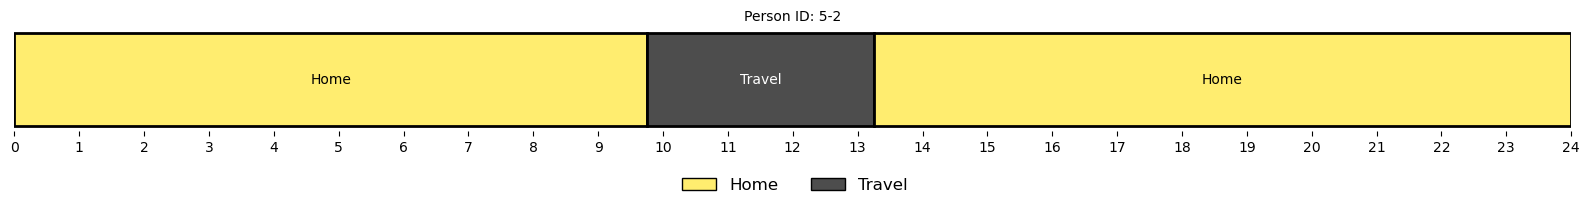

In [5]:
pam_population = read.load_travel_diary(
    trips=travel_diaries, trip_freq_as_person_freq=True
)
print(pam_population.stats)
pam_population.fix_plans()
print(pam_population.stats)
pam_population.random_person().plot()

In [6]:
def dt_to_min(dt) -> int:
    h, m, s = datetime_to_matsim_time(dt).split(":")
    return (int(h) * 60) + int(m)


def pam_to_population(population: Population) -> pd.DataFrame:
    """write trace of population. Ignoring trips."""
    record = []
    for uid, (hid, pid, person) in enumerate(population.people()):
        for i in range(0, len(person.plan) - 1, 2):
            record.append(
                [
                    uid,
                    hid,
                    person.plan[i].act,
                    dt_to_min(person.plan[i].start_time),
                    dt_to_min(person.plan[i + 1].end_time),
                ]
            )
        record.append(
            [
                uid,
                hid,
                person.plan[-1].act,
                dt_to_min(person.plan[-1].start_time),
                dt_to_min(person.plan[-1].end_time),
            ]
        )

    df = pd.DataFrame(record, columns=["pid", "hid", "act", "start", "end"])
    df["duration"] = df.end - df.start
    return df


population = pam_to_population(population=pam_population)

population.describe()

,pid,hid,start,end,duration
count,175.000000,175.000000,175.000000,175.000000,175.000000
mean,17.520000,1.685714,686.988571,1007.902857,320.914286
std,11.502044,0.921375,416.041844,301.367566,262.947656
min,0.000000,1.000000,0.000000,348.000000,6.000000
25%,8.000000,1.000000,465.000000,785.000000,52.000000
50%,17.000000,1.000000,805.000000,950.000000,320.000000
75%,28.000000,3.000000,967.000000,1308.500000,527.500000
max,38.000000,3.000000,1325.000000,1440.000000,962.000000


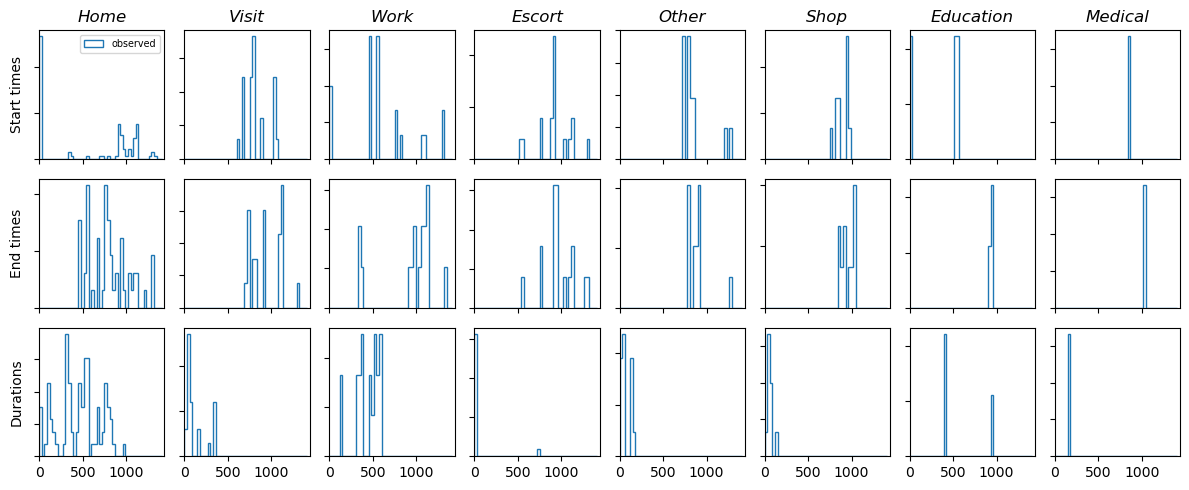

In [7]:
_ = times_distributions_plot(population, ys={})

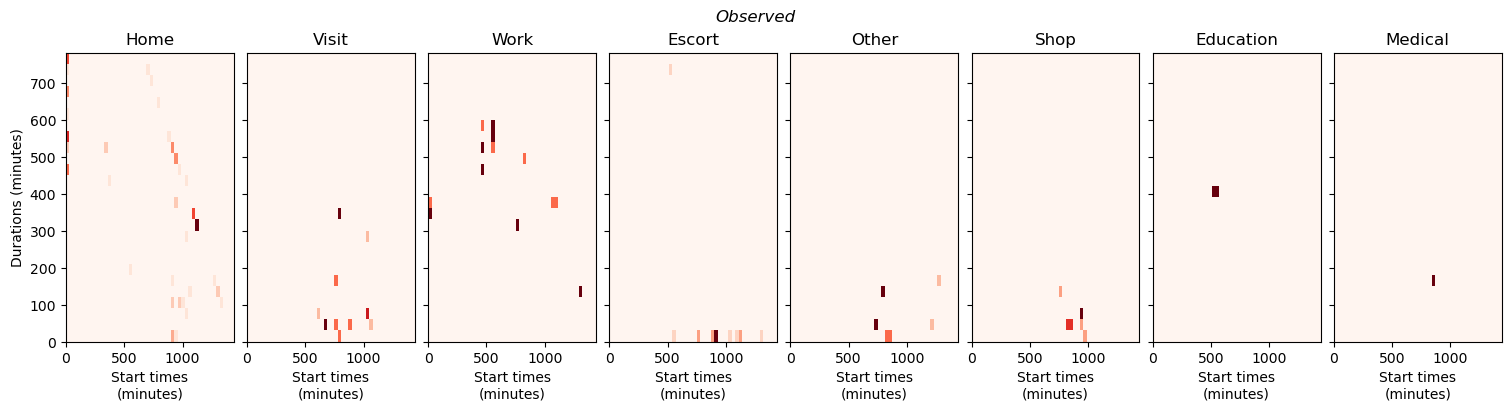

In [8]:
_ = joint_time_distributions_plot(population, ys={})

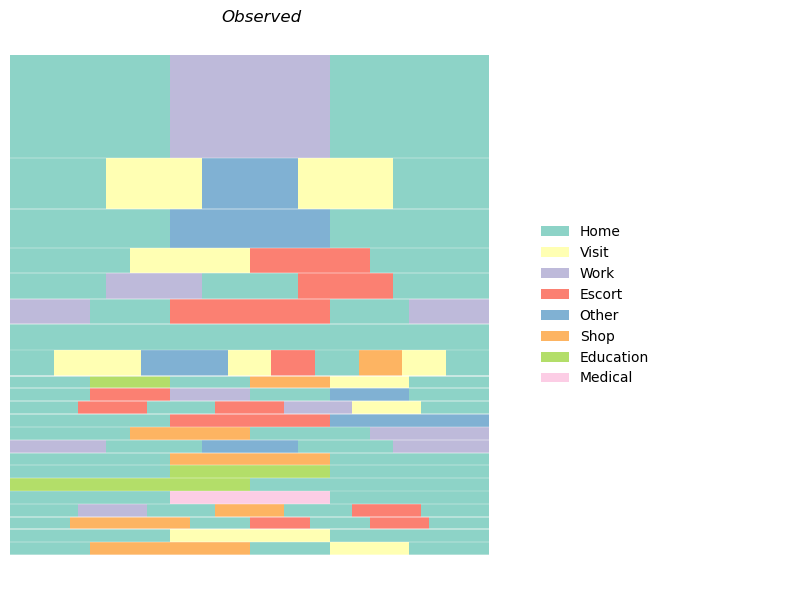

In [9]:
_ = sequence_prob_plot(population, ys={}, figsize=(8, 6))

In [10]:
write_path = write_dir / "nts_toy_population.csv"
write_path.parent.mkdir(exist_ok=True)
population.to_csv(write_path, index=False)

In [11]:
def pam_to_population_home_based_plans_only(
    population: Population,
) -> pd.DataFrame:
    """Convert population to trace. Only home-based plans are included."""
    record = []
    for uid, (hid, pid, person) in enumerate(population.people()):
        person_record = []
        for i in range(0, len(person.plan) - 1, 2):
            person_record.append(
                [
                    uid,
                    hid,
                    person.plan[i].act,
                    dt_to_min(person.plan[i].start_time),
                    dt_to_min(person.plan[i + 1].end_time),
                ]
            )
        person_record.append(
            [
                uid,
                hid,
                person.plan[-1].act,
                dt_to_min(person.plan[-1].start_time),
                dt_to_min(person.plan[-1].end_time),
            ]
        )
        if (person_record[0][2] == "home") and (person_record[-1][2] == "home"):
            record.extend(person_record)

    df = pd.DataFrame(record, columns=["pid", "hid", "act", "start", "end"])
    df["duration"] = df.end - df.start
    return df


home_population = pam_to_population_home_based_plans_only(pam_population)

write_path = write_dir / "nts_toy_home_population.csv"
write_path.parent.mkdir(exist_ok=True)
home_population.to_csv(write_path, index=False)